## Import Packages

In [1]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools

import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.rnn_models import SMILESModel as Model
from utils.rnn_models import Tokenizer

## Curate Dataset

<!-- - The vocabulary of SMILES is downloaded from [DeepChem vocab](https://github.com/deepchem/deepchem/blob/2.4.0/deepchem/feat/tests/data/vocab.txt) -->
- The convertion from SMILES to molecule is unique but not vice versa. SMILES augmentation is usually required to learn non-canonical SMILES. As a result, instead of writing SMILES strings to files, we designed a `pytorch.utils.data.Dataset` to sample various SMILES for a single molecule on the fly during training.

In [2]:
class SMILESDataset(Dataset):
    def __init__(self, df, augment=True):
        self.all_df = df
        self.augment = augment

    def _featurize(self, mol):
        smi = Chem.MolToSmiles(mol, doRandom=self.augment)
        return smi
    
    def __getitem__(self, idx):
        mol = self.all_df.iloc[idx]["ROMol"]
        smi = self._featurize(mol)
        pka = self.all_df.iloc[idx]["pKa"]
        return smi, float(pka)
    
    def __len__(self):
        return self.all_df.shape[0]


class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def collate(self, data):
        smis = [smi for smi, pka in data]
        max_len = max([len(smi) for smi in smis])
        padded_smis = [list(smi)+["PAD"]*(max_len-len(smi)) for smi in smis]
        X = [self.tokenizer.encode(smi) for smi in padded_smis]
        X = torch.Tensor(X).long()
        Y = torch.Tensor([pka for smi, pka in data]).reshape(-1, 1).float()
        return X, Y

In [3]:
infile = "../data/combined_training_datasets_unique.sdf"
all_df = PandasTools.LoadSDF(infile)
name = os.path.splitext(os.path.basename(infile))[0]
tokenizer = Tokenizer()
print(tokenizer.vocab)

[11:32:53] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


['PAD', 'UNK', 'Br', 'Cl', 'H', 'N', 'O', 'S', 'P', 'F', 'I', 'b', 'c', 'n', 'o', 's', 'p', '[', ']', '(', ')', '.', ' ', '=', '#', '+', '-', ':', '~', '@', '*', '%', '/', '\\', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Hyperparameters

In [4]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

datadir = "."
ratio = 0.1
batch_size = 16
augment = True
vocab_size = len(tokenizer.vocab)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Split Dataset

In [5]:
# split
nsamples = all_df.shape[0]

print(f"Number of samples: {nsamples}")
val_size = int(nsamples*ratio)
val_size = int(nsamples*ratio)
val_indices = np.random.choice(nsamples, val_size, replace=False)
train_indices = set(range(nsamples)) - set(val_indices.tolist())
train_indices = list(train_indices)

df_train = all_df.iloc[train_indices]
df_test = all_df.iloc[val_indices]
print(f"Size of training set: {df_train.shape[0]}, Size of test set: {df_test.shape[0]}")
## batching
instance = Collate(tokenizer)
collate_fn = instance.collate
train_loader = DataLoader(SMILESDataset(df_train, augment), \
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(SMILESDataset(df_test, augment), \
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Number of samples: 5994
Size of training set: 5395, Size of test set: 599


## Model

In [6]:
def train_epoch(dataloader, model, clip, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [7]:
epochs = 250
lr = 1e-3
emb_dim = 16
hidden_dim = 32
dropout = 0.3
n_layers = 3
clip = 5
model = Model(vocab_size, emb_dim, hidden_dim, n_layers, dropout=dropout, bidirectional=True)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, clip, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

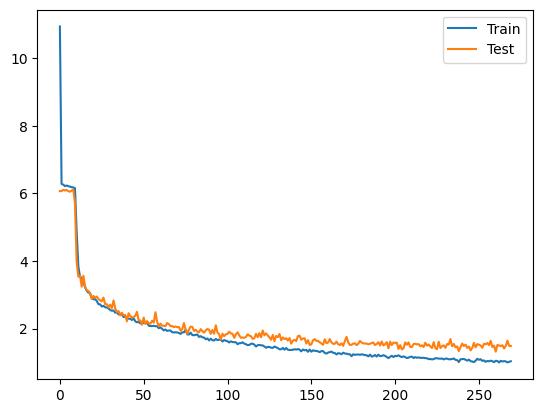

In [17]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(2.1298)


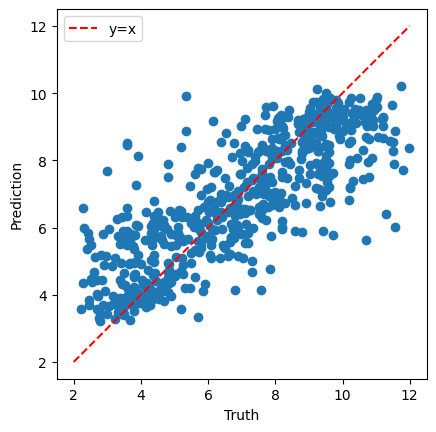

In [18]:
model.eval()
with torch.no_grad():
    truth = []
    pred = []
    for idx, row in df_test.iterrows():
        mol = row["ROMol"]
        y = float(row["pKa"])
        smi = Chem.MolToSmiles(mol, doRandom=True)
        tensor = torch.Tensor(tokenizer.encode(smi)).reshape(1, -1)
        p = model(tensor.long())
        pred.append(p)
        truth.append(y)
    l = nn.functional.mse_loss(torch.Tensor(pred).float(), torch.Tensor(truth).float())
    print(l)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()